# Plot Data Transfer

This notebook plot data transfers.

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import re
import gzip
import os

In [2]:
def get_proxystore_stats(task_dict) -> list[dict]:
    stats = []
    for key, data in task_dict['time']['proxy'].items():
        key_id = key.split("'")[1]
        connector = key.split('(')[0][:-3]
        key_stats = {'uuid': key_id, 'method': task_dict['method'], 'connector': connector}

        assert len(data['attributes']) == 1
        if 'store.get.object_size' in data['attributes']:
            key_stats['size_bytes'] = data['attributes']['store.get.object_size']
            key_stats['op'] = 'get'
            key_stats['approx_start_timestamp'] = (
                task_dict['timestamp']['compute_started'] + task_dict['time']['deserialize_inputs']
            )
        elif 'store.put.object_size' in data['attributes']:
            key_stats['size_bytes'] = data['attributes']['store.put.object_size']
            key_stats['op'] = 'put'
            key_stats['approx_start_timestamp'] = task_dict['timestamp']['compute_ended']
        else:
            raise AssertionError('Missing size attribute')

        prefix = 'store.' + key_stats['op']
        # NOTE: ProxyStore incorrecly converts NS to MS by dividing by 1000 so the
        # value here is off by 1000 and we account for that when converting to seconds.
        # Will be fixed in ProxyStore v0.6.5: https://github.com/proxystore/proxystore/issues/535
        key_stats['total_time'] = data['times'][prefix]['last_time_ms'] / 1000_000
        key_stats['connector_time'] = data['times'][f'{prefix}.connector']['last_time_ms'] / 1000_000
        if key_stats['op'] == 'get':
            key_stats['serialize_time'] = data['times'][f'{prefix}.deserialize']['last_time_ms'] / 1000_000
        elif key_stats['op'] == 'put':
            key_stats['serialize_time'] = data['times'][f'{prefix}.serialize']['last_time_ms'] / 1000_000
        stats.append(key_stats)
    return stats

In [3]:
def load_data_stats(results_json: Path, method: str):
    stats = []
    with open(results_json) as fp:
        for line in fp:
            row = json.loads(line)
            if row['method'] != method:
                continue
            stats.extend(get_proxystore_stats(row))
    return pd.DataFrame(stats)

In [4]:
run_path = Path('/eagle/ExaMol/mofa/mof-generation-at-scale/scripts/prod-runs/450-nodes/')

assemble_data = load_data_stats(run_path / 'assembly-results.json', method='assemble_many')
process_data = load_data_stats(run_path / 'generation-results.json', method='process_ligands')
md_data = load_data_stats(run_path / 'simulation-results.json', method='run_molecular_dynamics')

data = pd.concat([assemble_data, process_data, md_data], ignore_index=True)

data['approx_start_timestamp'] = data['approx_start_timestamp'] - data['approx_start_timestamp'].min()
data['connector_mbps'] = (data['size_bytes'] / 1e6) / data['connector_time']
data['effective_mbps'] = (data['size_bytes'] / 1e6) / data['total_time']

data.head()

,uuid,method,connector,size_bytes,op,approx_start_timestamp,total_time,connector_time,serialize_time,connector_mbps,effective_mbps
0,67acc94c-898a-4f11-bba2-69969dddeab8,assemble_many,Redis,36872,get,8.667038,0.003552,0.003323,0.000176,11.094382,10.379187
1,6b8a40ef-74c6-4d03-a521-d77c7e61a077,assemble_many,Redis,1007906,put,22.961559,0.002572,0.001697,0.000869,593.783194,391.867524
2,939074be-86af-4e31-b0ef-b2a3d04399f6,assemble_many,Redis,36872,get,6.292581,0.001943,0.001752,0.000145,21.043524,18.972221
3,4bc92553-a925-40f2-bc2e-19ad107226ca,assemble_many,Redis,1004018,put,22.976446,0.002022,0.001168,0.000848,859.483035,496.604699
4,7c7005f1-5947-48db-892d-0ceaa205a9ab,assemble_many,Redis,36872,get,8.666914,0.003654,0.003468,0.000139,10.632104,10.089581


In [5]:
def plot_size_speed_scatter(data):
    fig, axs = plt.subplots(1, 2, sharey=True) #figsize=(3.5, 2.25))

    io = {'get': 'input', 'put': 'output'}
    colors = plt.get_cmap('tab10').colors

    for col, speed in enumerate(('connector_mbps', 'effective_mbps')):
        ax = axs[col]
        for i, method in enumerate(data['method'].unique()):
            for op, marker in zip(['get', 'put'], ['o', 'x']):
                subdata = data[(data['op'] == op) & (data['method'] == method)]
                ax.scatter(
                    x=subdata['size_bytes'] / 1000_000,
                    y=subdata[speed],
                    color=colors[i],
                    marker=marker,
                    label=f'{method} {io[op]}',
                    s=20,
                )
        ax.set_title(speed)
        ax.set_xlabel('Object Size (MB)')
        ax.set_ylabel('Bandwidth (MB/s)')

    axs[1].legend(loc='upper right', fontsize=8, bbox_to_anchor=(1.01, 1.01))

    fig.tight_layout()
    plt.show()

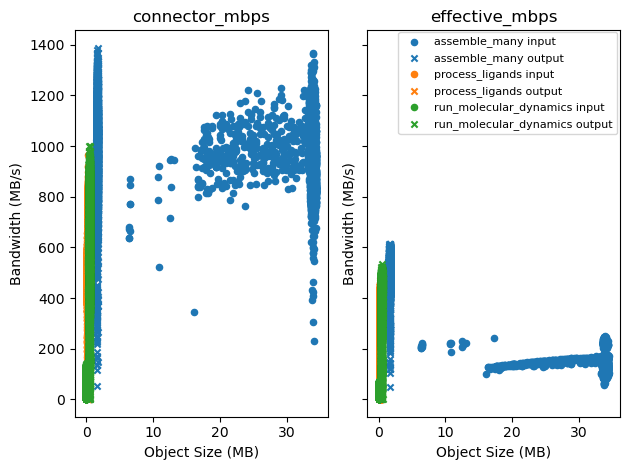

In [6]:
plot_size_speed_scatter(data)

In [7]:
def plot_speed_hist(data):
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 1.75))

    io = {'get': 'input', 'put': 'output'}
    colors = plt.get_cmap('tab10').colors
    bins = np.linspace(0, 2, 20)

    labels = {
        'assemble_many': 'Assembly',
        'process_ligands': 'RDKit/OpenBabel',
        'run_molecular_dynamics': 'LAMMPS',
    }

    ignore = data[(data['method'] == 'run_molecular_dynamics') & (data['op'] == 'get')]
    data = data.drop(ignore.index)
    
    for i, method in enumerate(data['method'].unique()):
        subdata = data[data['method'] == method]
        speed_data = subdata['connector_mbps'] / 1000
        ax.hist(
            speed_data,
            bins,
            color=colors[i],
            label=labels[method],
            alpha=0.5,
            weights=np.ones(len(speed_data)) / len(speed_data) * 100
        )
    ax.set_xlabel('Bandwidth (GB/s)', fontsize=8.5)
    ax.set_ylabel('Percent (%)', fontsize=8.5)
    ax.set_xlim([0, 2])

    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    
    ax.legend(loc='upper right', fontsize=8, bbox_to_anchor=(1.01, 1.01))

    return fig

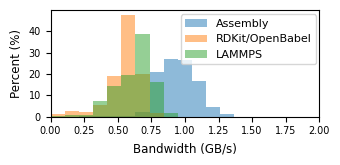

In [8]:
fig = plot_speed_hist(data)
fig.tight_layout()
fig.savefig('figures/transfer-bandwidth-450.pdf')

In [9]:
def plot_speed_hist(data):
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 1.75))

    io = {'get': 'input', 'put': 'output'}
    colors = plt.get_cmap('tab10').colors
    bins = np.linspace(0, 2, 40)

    labels = {
        'assemble_many': 'Assembly',
        'process_ligands': 'RDKit/OpenBabel',
        'run_molecular_dynamics': 'LAMMPS',
    }

    ignore = data[(data['method'] == 'run_molecular_dynamics') & (data['op'] == 'get')]
    data = data.drop(ignore.index)
    
    for i, method in enumerate(data['method'].unique()):
        subdata = data[data['method'] == method]
        speed_data = subdata['size_bytes'] / 1000_000
        ax.hist(
            speed_data,
            bins,
            color=colors[i],
            label=labels[method],
            alpha=0.5,
            weights=np.ones(len(speed_data)) / len(speed_data) * 100
        )
    ax.set_xlabel('Object Size (MB)')
    ax.set_ylabel('Percent (%)')

    ax.legend(loc='upper right', fontsize=8, bbox_to_anchor=(1.01, 1.01))

    return fig

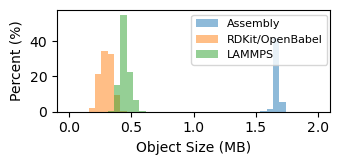

In [10]:
fig = plot_speed_hist(data)
fig.tight_layout()
plt.show()

In [11]:
def plot_transfer_time_histogram(data):
    fig, axs = plt.subplots(2, 1, sharey=True) #figsize=(3.5, 2.25))

    io = {'get': 'input', 'put': 'output'}
    colors = plt.get_cmap('tab10').colors
    bins = np.linspace(0, 0.05, 100)
    
    for col, metric in enumerate(('connector_time', 'total_time')):
        ax = axs[col]
        for i, method in enumerate(data['method'].unique()):
            subdata = data[data['method'] == method]
            ax.hist(
                subdata[metric],
                bins,
                color=colors[i],
                label=f'{method}',
                # density=True,
                alpha=0.5,
                weights=np.ones(len(subdata[metric])) / len(subdata[metric]) * 100
            )
        ax.set_title(metric)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Percent (%)')
        # ax.set_yscale('log')

    axs[1].legend(loc='upper right', fontsize=8, bbox_to_anchor=(1.01, 1.01))

    fig.tight_layout()
    plt.show()

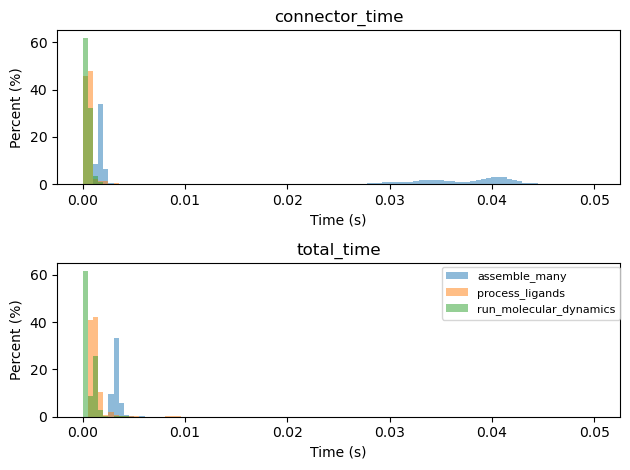

In [12]:
plot_transfer_time_histogram(data)